<a href="https://colab.research.google.com/github/Maxime9197/LUX-HESS-experience/blob/main/Q_lorimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

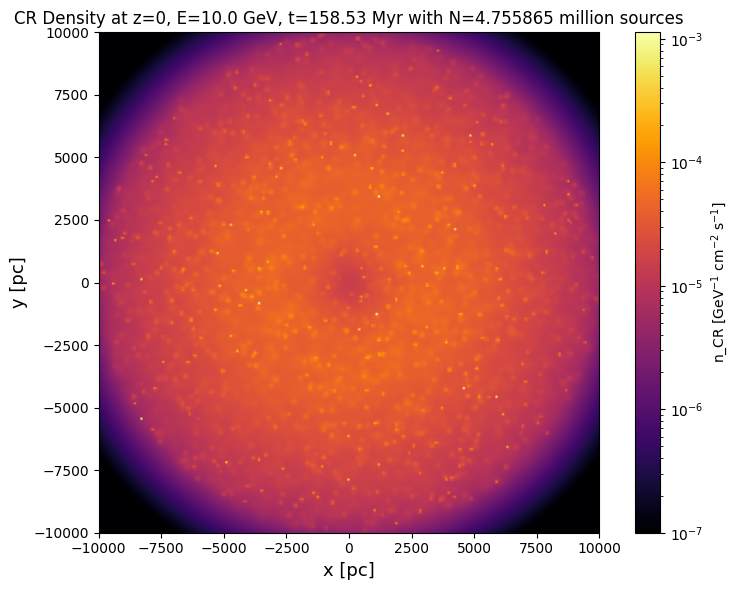

3.7876952193171945e-09 0.001126712976061492


In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, jit, lax
import matplotlib.colors as mcolors



jax.config.update("jax_enable_x64", True)
key = jax.random.PRNGKey(0)

# Constants
D0 = 1e28
delta = 0.6
zmax = 1e3  # pc
zmax_cm = zmax * 3.086e18
zcr = 4 * zmax_cm / jnp.pi
b0 = 1e-16
Q0 = 7.8e49
E_fixed = 1e2  # GeV
supernova_rate = 3 * 10**-2  # Supernovae per year
c = 3e10
R_sun = 8.5  # kpc
A = 41       # kpc^-2
B = 1.9
C = 5.0


# Grid
grid_size = 230
extent_pc = 10000
extent_cm = extent_pc * 3.086e18

def t_loss(E):
    return 1/(b0*E)
t_now = t_loss(E_fixed)
N_sources =  int(supernova_rate * t_now / 3.154e7)

def E_s(E, t):
    return E / (1 - b0 * E * t)

def l2(E, t):
    Es = E_s(E, t)
    term1 = E**(delta - 1)
    term2 = Es**(delta - 1)
    return (4 * D0 / (b0 * (1 - delta))) * (term1 - term2)

def theta3(z, q, N=100):
    n = jnp.arange(1, N + 1)
    series = jnp.sum(q ** (n**2) * jnp.cos(2 * n * z))
    return 1 + 2 * series

def chi_function(l2_hat, N=100):
    q = jnp.exp(-l2_hat)
    theta3_0 = theta3(0.0, q, N)
    theta3_pi2 = theta3(jnp.pi / 2, q, N)
    return (theta3_0 - theta3_pi2) / jnp.pi

def Q_lorimer(E,gamma,R):
    return Q0*(R / R_sun)**B * jnp.exp(-C * (R - R_sun) / R_sun)*E**(-gamma)

def S(R):
    return Q0*(R / R_sun)**B * jnp.exp(-C * (R - R_sun) / R_sun)


def Q(E,gamma_val):
    return Q0*E**(-gamma_val)

def green_core(E, r, t, gamma_val,R_source):
    Es = E_s(E, t)
    l2_val = l2(E, t)
    l2_hat = l2_val / zcr**2
    prefactor = 1.0 / (jnp.pi * l2_val * zcr)
    exp_term = jnp.exp(-r**2 / l2_val)
    term = 1 - b0 * E * t
    r_kpc = r / 3.086e21  # conversion en kpc
    energy_term = Q_lorimer(Es, gamma_val,R_source) / term**2
    chi_val = chi_function(l2_hat)
    return prefactor * exp_term * energy_term * chi_val


def green_correction(E, r, t, gamma_val,R_source):
    return lax.cond(
        b0 * E * t < 1.0,
        lambda _: green_core(E, r, t, gamma_val, R_source),
        lambda _: 0.0,
        operand=None
    )


def sample_disk(key, N, R_max):
    key_r, key_theta = jax.random.split(key)
    r = R_max * jnp.sqrt(jax.random.uniform(key_r, (N,)))
    theta = 2 * jnp.pi * jax.random.uniform(key_theta, (N,))
    x = r * jnp.cos(theta)
    y = r * jnp.sin(theta)
    return x, y

# === Sampling keys ===
key, key_pos, key_time, key_gamma = jax.random.split(key, 4)

# Sample sources
x_i, y_i = sample_disk(key_pos, N_sources, extent_cm)
t_i = t_now * jax.random.uniform(key_time, (N_sources,))
gamma_min, gamma_max = 2.0, 2.4
gamma_i = gamma_min + (gamma_max - gamma_min) * jax.random.uniform(key_gamma, (N_sources,))

# Green function for each source
def green_i(x, y, t0, xi, yi, ti, gi):
    r = jnp.sqrt((x - xi)**2 + (y - yi)**2)
    R_source = jnp.sqrt(xi**2 + yi**2) / 3.086e21
    dt = t0 - ti
    return green_correction(E_fixed, r, dt, gi, R_source)*c/(4*jnp.pi)



v_green = vmap(green_i, in_axes=(None, None, None, 0, 0, 0, 0))

# Grid
x_vals = jnp.linspace(-extent_cm, extent_cm, grid_size)
y_vals = jnp.linspace(-extent_cm, extent_cm, grid_size)
X, Y = jnp.meshgrid(x_vals, y_vals)

# Density
@jit
def compute_ncr(xg, yg):
    return v_green(xg, yg, t_now, x_i, y_i, t_i, gamma_i).sum()


ncr_grid = vmap(
    lambda x_row, y_row: vmap(compute_ncr)(x_row, y_row)
)(X, Y)

"""
# Mask outside the disk
R_grid = jnp.sqrt(X**2 + Y**2)
mask = R_grid > extent_cm +100*3.086e18
ncr_masked = jnp.where(mask, jnp.nan, ncr_grid)
"""

plt.figure(figsize=(8, 6))
plt.imshow(ncr_grid,
           extent=[-extent_pc, extent_pc, -extent_pc, extent_pc],
           origin='lower',
           cmap='inferno',
           norm=mcolors.LogNorm(vmin=1e-07, vmax= 1.1269927070627631e-3))
plt.colorbar(label='n_CR [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.xlabel('x [pc]',fontsize=13)
plt.ylabel('y [pc]',fontsize=13)
plt.title(f'CR Density at z=0, E={E_fixed} GeV, t={t_now/3.154e13:.2f} Myr with N={N_sources/1e6} million sources')
plt.tight_layout()
plt.show()

print(ncr_grid.min(), ncr_grid.max())